# Great Artists: A neural network model that identifies the artist based on the artwork

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [2]:
artists = pd.read_csv('../input/artists.csv')
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Data Processing

In [3]:
'''In order to ensure we only pick artists with a sufficient number of 
artwork we filter out artists with less than 200 paintings.

'''
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

In [4]:
'''I am assinging a class weight for each artist to make sure any one artist is not overrepresented.
Since Van Gogh has the most paintings he would have the lowest class weight and correspondingly
Marc Chagall would have the highest class weight. To calculate class weight I am doing a simple weighted sum.
'''
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [5]:
#Converting class weights into a dictionary for later use
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [6]:
'''
There is some error with Albrecht Dürer's name where the path is not ready properly.
As a temporary fix I manually insert a space in his name, replacing the original one and while
looking for his folder I replace that space again with an underscore and this seems to work.
Must investigate as to the underlying cause of this problem.
'''
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [7]:
# Explore images of top artists
images_dir = '../input/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/images/images/Vincent_van_Gogh
Found --> ../input/images/images/Edgar_Degas
Found --> ../input/images/images/Pablo_Picasso
Found --> ../input/images/images/Pierre-Auguste_Renoir
Found --> ../input/images/images/Albrecht_Dürer
Found --> ../input/images/images/Paul_Gauguin
Found --> ../input/images/images/Francisco_Goya
Found --> ../input/images/images/Rembrandt
Found --> ../input/images/images/Alfred_Sisley
Found --> ../input/images/images/Titian
Found --> ../input/images/images/Marc_Chagall


### Print few random paintings

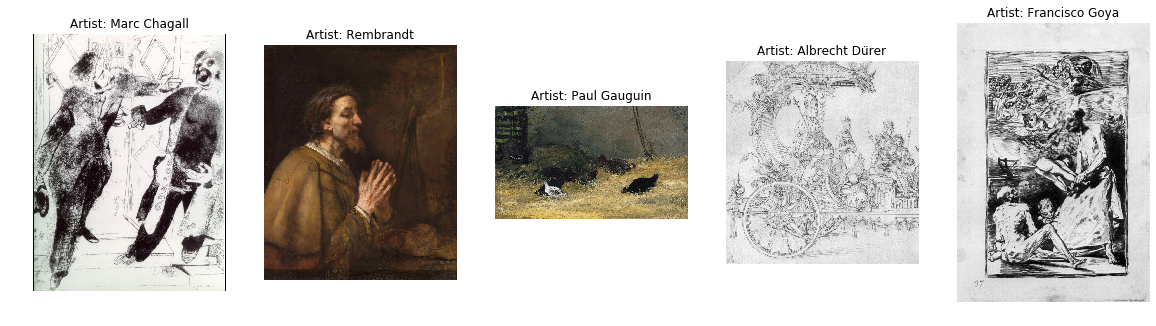

In [8]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation

In [9]:
'''Since we only have a few hundred artworks per artist,
I will be augmenting the data to increase the training data
size and the model performance'''
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


### Print a random painting and it's augmented version

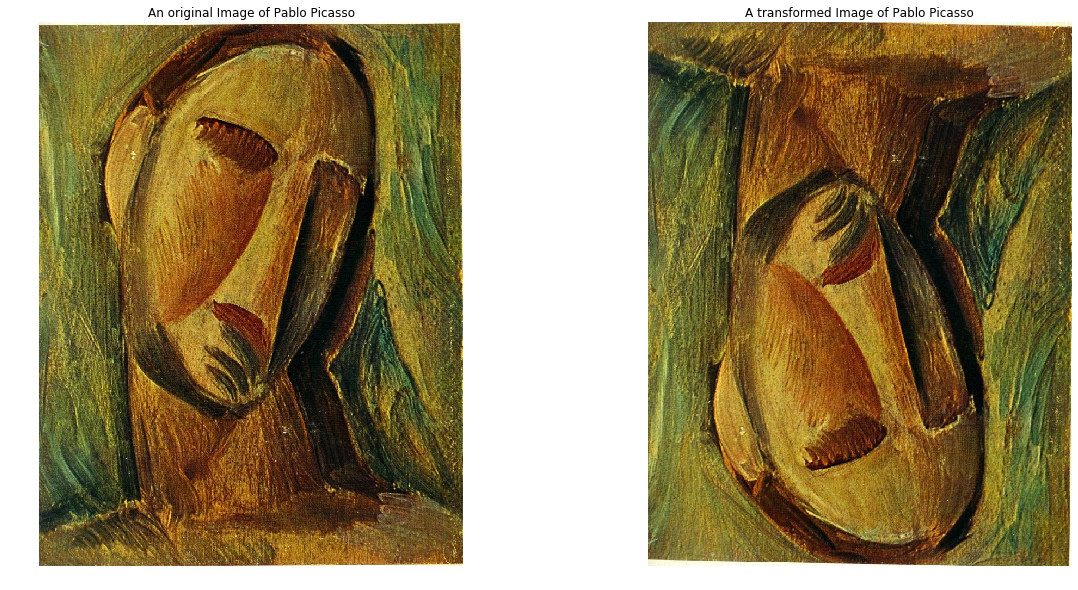

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Build Model

In [11]:
# Loading the pre-trained baseline model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [12]:
# Adding layers to the baseline model
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [14]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [15]:
# Training the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
215/215 [==============================] - 86s 398ms/step - loss: 1.6053 - acc: 0.4974 - val_loss: 2.6225 - val_acc: 0.0767
Epoch 2/10
215/215 [==============================] - 77s 360ms/step - loss: 1.1855 - acc: 0.7100 - val_loss: 4.5539 - val_acc: 0.0590
Epoch 3/10
215/215 [==============================] - 79s 367ms/step - loss: 1.0592 - acc: 0.7728 - val_loss: 2.7359 - val_acc: 0.1191
Epoch 4/10
215/215 [==============================] - 80s 372ms/step - loss: 0.9458 - acc: 0.8186 - val_loss: 2.3318 - val_acc: 0.2748
Epoch 5/10
215/215 [==============================] - 81s 376ms/step - loss: 0.8428 - acc: 0.8518 - val_loss: 1.3612 - val_acc: 0.6509
Epoch 6/10
215/215 [==============================] - 81s 377ms/step - loss: 0.7465 - acc: 0.8693 - val_loss: 0.9938 - val_acc: 0.7700
Epoch 7/10
215/215 [==============================] - 83s 386ms/step - loss: 0.6512 - acc: 0.8959 - val_loss: 0.9777 - val_acc: 0.7901
Epoch 8/10
215/215 [==============================] - 8

In [16]:
# Freezing core ResNet layers and training again, this time with 50 epochs 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/50
215/215 [==============================] - 81s 375ms/step - loss: 0.3752 - acc: 0.9647 - val_loss: 0.8945 - val_acc: 0.7901
Epoch 2/50
215/215 [==============================] - 78s 360ms/step - loss: 0.3925 - acc: 0.9542 - val_loss: 0.8469 - val_acc: 0.8019
Epoch 3/50
215/215 [==============================] - 77s 360ms/step - loss: 0.3867 - acc: 0.9557 - val_loss: 0.8676 - val_acc: 0.7936
Epoch 4/50
215/215 [==============================] - 78s 363ms/step - loss: 0.3838 - acc: 0.9571 - val_loss: 0.8708 - val_acc: 0.8113
Epoch 5/50
215/215 [==============================] - 78s 364ms/step - loss: 0.3881 - acc: 0.9560 - val_loss: 0.7916 - val_acc: 0.8349
Epoch 6/50
215/215 [==============================] - 79s 368ms/step - loss: 0.3741 - acc: 0.9659 - val_loss: 0.8046 - val_acc: 0.8125
Epoch 7/50
215/215 [==============================] - 80s 371ms/step - loss: 0.3607 - acc: 0.9641 - val_loss: 0.8177 - val_acc: 0.8160
Epoch 8/50
215/215 [==============================] - 8

## Training graph

In [17]:
# Merging history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

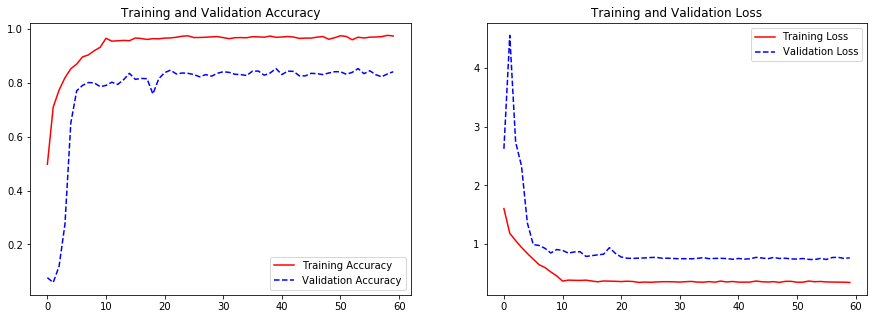

In [18]:
# Ploting the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

## Evaluate performance

In [19]:
# Predicting the accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

216/216 [==============================] - 93s 431ms/step - loss: 0.3312 - acc: 0.9878
Prediction accuracy on train data = 0.9878049


In [20]:
# Predicting the accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

54/54 [==============================] - 23s 428ms/step - loss: 0.7869 - acc: 0.8269
Prediction accuracy on CV data = 0.8269006


# Evaluate performance by predicting on random images from dataset

Using TensorFlow backend.


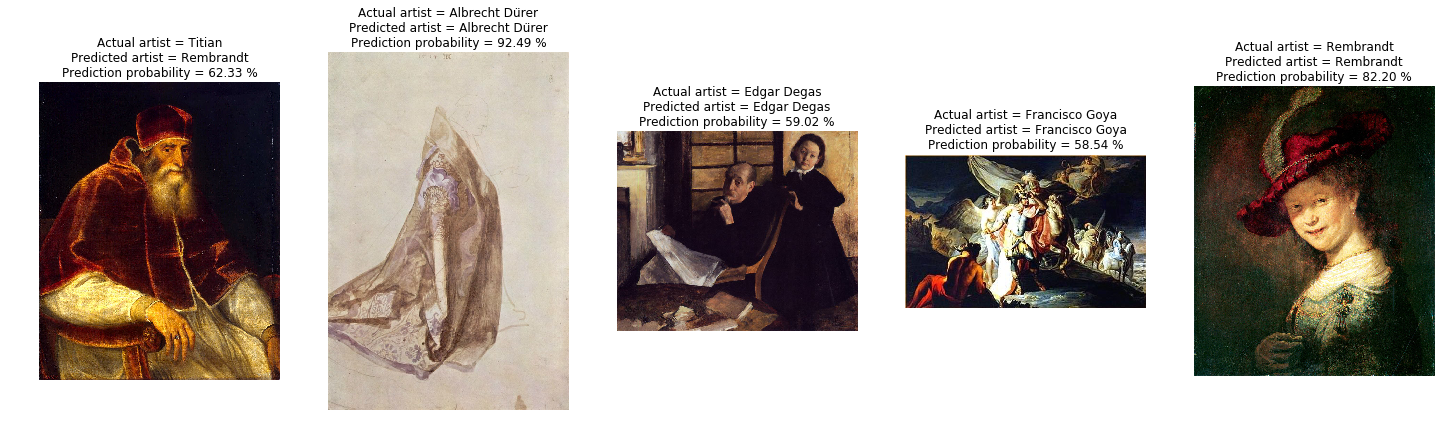

In [21]:
# Predicting
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

# Testing the model with a URL of a painting from the artist Titian

Predicted artist = Titian
Prediction probability = 89.73709344863892 %


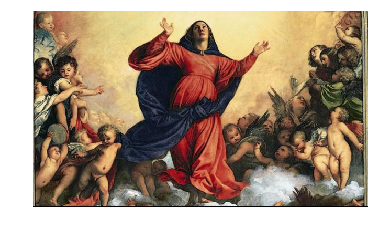

In [22]:
# Predict from web - this is an image of Titian.
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()